<hr style="border-top-width:4px; border-top-color: #00df;">

# Analysis of Covid-19 papers


* Mojtaba Roshana
* Roya Joulaei
<hr>
* Luca Giorgetti
* Emerson Rodrigues Vero filho
<hr style="border-top-width:4px; border-top-color: #00df;">


# Introduction
This distributed computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-CoV-2, and related coronaviruses. The dataset is a sub-sample of 1000 items taken from the original dataset that is composed of more than 75000 (and still growing) papers. This dataset is a part of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge (CORD-19). The research and related chal- lenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen- institute-for-ai/CORD-19-research-challenge


In [1]:
from dask.distributed import Client, SSHCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
import numpy as np
import csv
import functools
import seaborn as sn
import json
import time
import pandas as pd

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

from collections import Counter
from operator import add
from operator import itemgetter

import matplotlib.pyplot as plt

from operator import itemgetter
import numpy as np
from dask.utils import format_bytes
import itertools
from numpy.linalg import norm

<hr style="border-top-width:4px; border-top-color: #00df;">

# Architecture
Our cluster contains three virtual machines which are hosted in the CloudVeneto. Our schedular , which is the component of an operating system that decides which CPU the various tasks should run on and for how long they are allowed to do so, is the second machine (machine2). The rest of VMs and also the machine2 will run the workers.

In [2]:
machine1 = '10.67.22.93'
machine2 = '10.67.22.77'
machine3 = '10.67.22.134'

<hr style="border-top-width:4px; border-top-color: #00df;">

# Deploy a Dask cluster using SSH

It is easy to set up Dask on informally managed networks of machines using SSH . The SSHCluster function deploys a Dask Scheduler and Workers for us on a set of machine addresses that we provide. once the authentication keys have been exchanged between the client node and the scheduler/workers ones:

Also we set the dashboard on port 8080 to analyze the system

In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"}
                    ,worker_options={"n_workers":4})
client = Client(cluster)


In [6]:
client


<Client: 'tcp://10.67.22.77:45913' processes=12 threads=48, memory=93.25 GiB>

<hr style="border-top-width:4px; border-top-color: #00df;">

# Subsetting the dataset

We make a 200Gib volume and download the data inside. Then extract 1000 papers and put them inside other volume. The latter is then shared between the scheduler and the workers.

Our RAW data are in json format multiple line, therefore we convert them to single line json to make it readable.

In [17]:
!ls /mnt/nfs_share/test/new | wc -l # about 100Mb

1000


<hr style="border-top-width:4px; border-top-color: #00df;">

##  Task1) Word counter distributed algorithm <a class="anchor" id="MAPD_B_FP.2."></a>


We implement a distributed algorithm to count the occurrences of all the words inside a list of documents using Bag data-structure of DASK. Here, we explain the algorithm step by step and in the end we wrap all the steps inside a single function in order to test the computational time required by the algorithm as a function of the number of cluster workers and the number of data partitions. 

The algorithm is divided into two parts:

* Map phase: for each document $D_i$, it produces the set of intermediate pairs $(w, cp(w))$, one for each word $w \in D_i$, where $cp(w)$ is the number of occurrences of $w$ in $D_i$.

* Reduce phase: for each word $w$, gather all the previous pairs $(w, cp(w))$ and return the final pair $(w,c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n {cp}_{k} (w)$.

### MAP PHASE

In [4]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)
js = bag.map(json.loads).repartition(50)
js

dask.bag<repartition, npartitions=50>

Firstly, we merge the divided paragraphs for every single paper into a unique text. Hence, after this operation, we have 1000 paper's body texts for the following analysis.

In [5]:
def merge_json(data):
    all_text=''
    for t in data:
        all_text+=t['text'] # only text part of budy text
    return all_text

texts = js.pluck("body_text").map(merge_json) # the bag with only text part of data
#texts.take(1)

## Text Cleaning in Natural Language Processing(NLP)

So consider the text contains different symbols and words which doesn't convey meaning. So we will remove them before counting:

* the stop-words

* the punctuation

In [6]:
def cleaner(text):

    stop_words = stopwords.words('english')
    text_tokens=word_tokenize(text)
    no_word=['et','using','used','also','may','one']
    tokens_without_sw=[word.lower() for word in text_tokens if not word.lower() in stop_words + no_word and word.isalpha()]
    return tokens_without_sw

text_clean = texts.map(cleaner)
text_clean.take(1)[0][:5]

['pneumonia', 'manifests', 'acute', 'respiratory', 'failure']

the Dask Bag `text_clean`  contains a list of words for each document; in the last step of the map phase, we map a simple function to count the frequency of each word. 
we organize the result into the path:

 {'word': 'word_name', 'counts': count_val}

In [7]:
# convert list to list of directories
# where the unique words and their frequency is stored

def count(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    words_counted = [{"word":x , "frequency": y} for x,y in counts.items()]
    return words_counted

words = text_clean.map(count)
#words.take(1)

## Reduce phase

* For each word w, we gather all the previous pairs (w, cp(w)) and return the final pair (w,c(w)) where c(w) is the number of occurrences of w for all the Documents.
* Trough the DASK function foldby, we sum the counts for every unique word over all the papers. Foldby provides a combined groupby and reduce for efficient parallel split-apply-combine tasks.


In [8]:
def sumation(total, x):
    return total+x['frequency']

# using flatten to un-fold the dictionary into a list-like object
# using foldby to sum all unique words 

All_counts = words.flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()

Sort the result depending on the number of occurrences

In [41]:
# sorting
All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
All_counts_sorted[:10]

[('patients', 10046),
 ('study', 9386),
 ('data', 8821),
 ('health', 6062),
 ('cells', 5633),
 ('time', 5011),
 ('model', 4912),
 ('disease', 4831),
 ('infection', 4536),
 ('studies', 4495)]

## Analysis of the top words

At the end of the algorithm we analyze the top words and see how they are related to the
viruses and the research by creating a barplot of the top words


In [43]:
freq = [All_counts_sorted[i][1] for i in range(0,len(All_counts_sorted))]
word = [All_counts_sorted[i][0] for i in range(0,len(All_counts_sorted))]

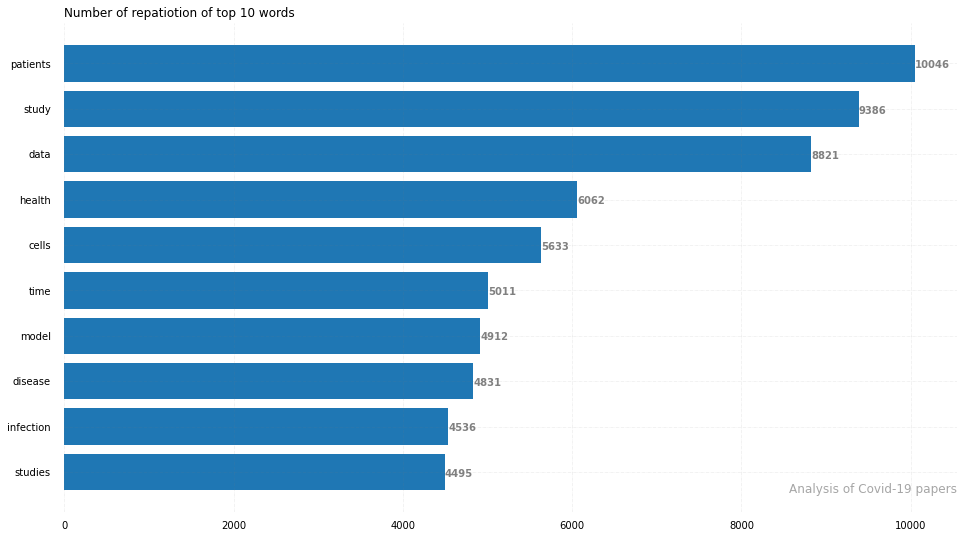

In [44]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(word[:10], freq[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 words',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

<hr style="border-top-width:4px; border-top-color: #00df;">

## Optimazing the number of partitions 

In order to optimize the number of partitions and workers, We now experiment with the parallelization parameters of Dask, such as trying the diffrent number of workers and the number of partitions in the dataset


In [53]:
partitions=[1,3,9,50,100,500,1000]

In [50]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)

def timing_part1(partitions):
    i = time.time() 

    #process
    All_counts = (bag.map(json.loads).repartition(partitions).pluck('body_text').map(merge_json).map(cleaner)
                  .map(count).flatten().foldby('word', binop=sumation, initial=0, combine=add, combine_initial=0)
                  .compute())
    
    f = time.time()
    
    
    return (f-i)

In [54]:
#timing for part 1 _ 12 workers

ts_w3_1=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_part1(p)
    print('for partitions=',p,'timing is :', t)
    ts_w3_1[c]=t
    c=c+1
    client.restart()
    time.sleep(1)


for partitions= 1 timing is : 34.242228507995605
for partitions= 3 timing is : 25.617029428482056
for partitions= 9 timing is : 16.041065454483032
for partitions= 50 timing is : 12.898420810699463
for partitions= 100 timing is : 13.612406492233276
for partitions= 500 timing is : 14.289178371429443
for partitions= 1000 timing is : 16.553388833999634


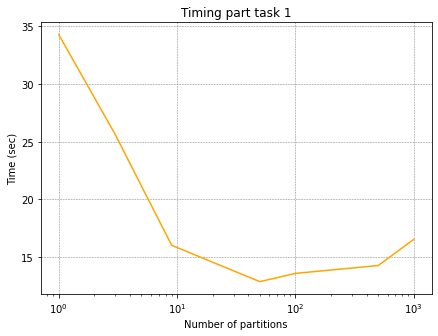

In [61]:
plt.figure(figsize=(7,5))
plt.plot(partitions,ts_w3_1,c='orange')
plt.xscale('log')
plt.xlabel('Number of partitions')
plt.ylabel('Time (sec)')
plt.title('Timing part task 1')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

<hr style="border-top-width:4px; border-top-color: #00df;">

# Task2) Which are the worst and best-represented countries in the research?
In this part, we take the documents and convert them in a dataframe data structure in order to figure out the countries that are most active in the research. To do this, we use the country of the authors.
Moreover, we do the same for the universities (affiliations)



In [63]:
#let's create the function to extract the needed features
def feat(record):
    name=surname=university=country=''
    
    name = record['first']
    surname = record['last']
    
    if record['affiliation'] == {}:
        university = 'Not given'
        country = 'Not given'
    
    else: #affiliation not void
        if 'institution' in record['affiliation'].keys() and record['affiliation']['institution'] != '': university = record['affiliation']['institution']
        else: university = 'Not given'
        
    if 'location' in record['affiliation'].keys() and 'country' in record['affiliation']['location'].keys() and record['affiliation']['location']['country'] != '':
        country = record['affiliation']['location']['country']
    else: country = 'Not given'
    
    return {
        'name':       name,
        'surname':    surname, 
        'university': university,
        'country':    country,
    }
        
       

Now, we map this function onto our Dask Bag, and finally put it into a Dask DataFrame


In [90]:
authors = js.pluck('metadata').pluck('authors').flatten().repartition(100)
authors_DataFrame = authors.map(feat).to_dataframe()
authors_DataFrame.head()

,name,surname,university,country
0,Rajae,Alkouh,Not given,Not given
1,Abdelilah,Rhalete,VI University Hospital,Morocco
2,Merbouh,Manal,VI University Hospital,Morocco
3,Aidouni,Ghizlane,Not given,Not given
4,Berrichi,Samia,VI University Hospital,Morocco


In [92]:
countries = authors_DataFrame.country.value_counts()

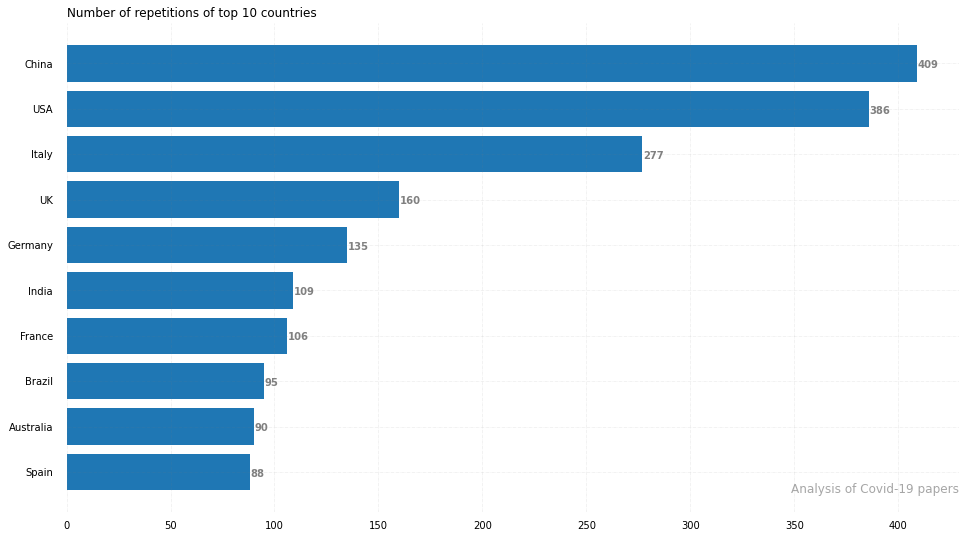

In [93]:
n=10
data = countries.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repetitions of top 10 countries',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

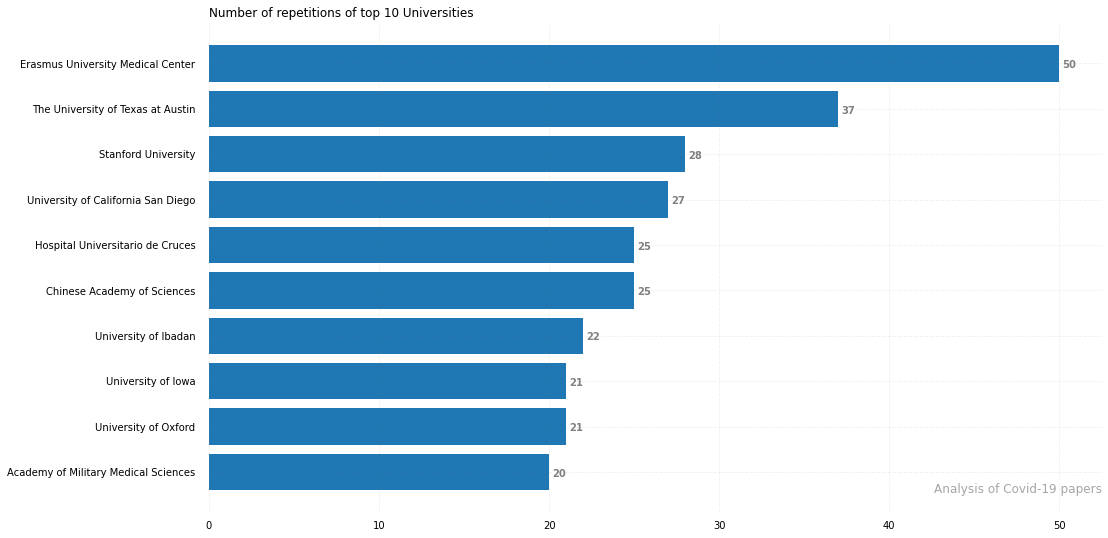

In [96]:
univs = authors_DataFrame.university.value_counts()
n=10
data = univs.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repetitions of top 10 Universities',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

 <hr style="border-top-width:4px; border-top-color: #00df;">

 ## Chek computation time with different partitions and workers


 Even in this case do multiple runs by changing the number of partitions and workers and then describe the behavior of the timings.

In [160]:
client.close()
cluster.close()

In [161]:
client.shutdown()


In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"},
                    worker_options={"n_workers":1})
client = Client(cluster)

* With [3,6,9,12,15] workers
* and partitions=[1,10,100,1000]

Timing for all the timings with different number of partition and number of workers:

In [119]:
workers= [3,6,9,12,15]
partitions=[1,10,100,1000]
times = np.zeros((len(workers),len(partitions)))

In [120]:
# timing for part 2

def timing_countries(partitions):
    i = time.time() #start taking time
    auth_df = (bag.map(json.loads).repartition(partitions)
               .pluck('metadata').pluck('authors').flatten().map(feat).to_dataframe())
    countries = authors_DataFrame.country.value_counts().nlargest(10).compute()
    f = time.time()
    return f-i

In [121]:
#timing for part 2 _ 3 workers

ts_w3_2=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_countries(p)
    print('for partitions=',p,'timing is :', t)
    ts_w3_2[c]=t
    c=c+1
    client.restart()
    time.sleep(1)
times[0]=ts_w3_2

for partitions= 1 timing is : 16.759646892547607
for partitions= 10 timing is : 8.243836641311646
for partitions= 100 timing is : 6.254657030105591
for partitions= 1000 timing is : 6.888153791427612


In [123]:
client.shutdown()
client.close()
cluster.close()

In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"},
                    worker_options={"n_workers":2})
client = Client(cluster)

In [127]:
#timing for part 2 _ 6 workers

ts_w6_2=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_countries(p)
    print('for partitions=',p,'timing is :', t)
    ts_w6_2[c]=t
    c=c+1
times[1]=ts_w6_2

for partitions= 1 timing is : 8.644251823425293
for partitions= 10 timing is : 4.280348777770996
for partitions= 100 timing is : 3.6952550411224365
for partitions= 1000 timing is : 4.233103275299072


In [128]:
client.close()
time.sleep(0.5)
cluster.close()
time.sleep(0.5)
client.shutdown()

In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"},
                    worker_options={"n_workers":3})
client = Client(cluster)

In [132]:
#timing for part 2 _ 9 workers

ts_w9_2=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_countries(p)
    print('for partitions=',p,'timing is :', t)
    ts_w9_2[c]=t
    c=c+1
times[2]=ts_w9_2

for partitions= 1 timing is : 7.189519166946411
for partitions= 10 timing is : 3.5329716205596924
for partitions= 100 timing is : 2.794503688812256
for partitions= 1000 timing is : 3.171191453933716


In [139]:
client.close()
time.sleep(0.5)
cluster.close()
time.sleep(0.5)
client.shutdown()

In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"},
                    worker_options={"n_workers":4})
client = Client(cluster)

In [141]:
#timing for part 2 _ 12 workers

ts_w12_2=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_countries(p)
    print('for partitions=',p,'timing is :', t)
    ts_w12_2[c]=t
    c=c+1
times[3]=ts_w12_2

for partitions= 1 timing is : 7.918588399887085
for partitions= 10 timing is : 3.180889844894409
for partitions= 100 timing is : 2.9956459999084473
for partitions= 1000 timing is : 3.3231751918792725


In [143]:
client.shutdown()
client.close()
cluster.close()

In [ ]:
cluster = SSHCluster([machine2, machine3,machine1,machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8080"},
                    worker_options={"n_workers":5})
client = Client(cluster)

In [158]:
#timing for part 2 _ 15 workers

ts_w15_2=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_countries(p)
    print('for partitions=',p,'timing is :', t)
    ts_w15_2[c]=t
    c=c+1
    #client.restart()
times[4]=ts_w15_2

for partitions= 1 timing is : 8.084995031356812
for partitions= 10 timing is : 3.3918862342834473
for partitions= 100 timing is : 3.226043939590454
for partitions= 1000 timing is : 3.204777956008911


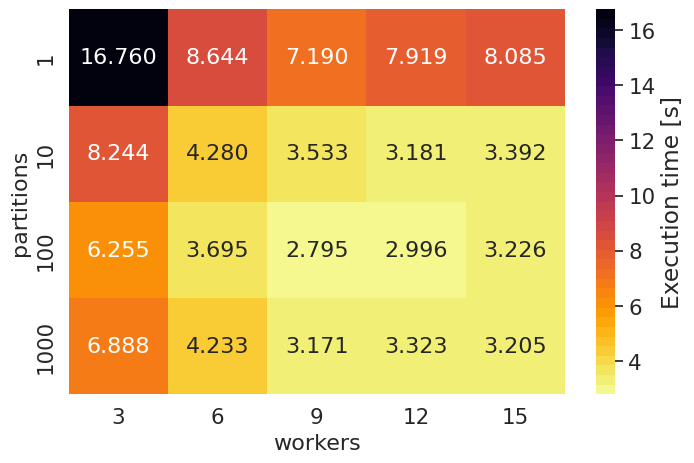

In [159]:
df_cm = pd.DataFrame(times.T, partitions, workers)
    # Plot the heatmap
plt.figure(figsize=(8,5))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
            cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.show()
plt.style.use('default')

Due to the plot we can say that best number of worker is 9 or 12 and best number of partition is 100.

But these numbers are not so reliable when they become so close especially in more than 9 number of workers. Maybe its better to chose more than 1000 data to analyze it better.

 <hr style="border-top-width:4px; border-top-color: #00df;">

# Task3) Get the embedding for the title of the papers

In NLP a common technique for performing analysis over a set of texts is to transform the text into a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of n × m where n is the number of words in the document and m is the size of the vector that represents the word.

In this project we use the pre-trained moedl , the structure of which can be seen in [source](https://fasttext.cc/docs/en/english-vectors.html)
<hr>
and it can be downloadeed from the

https://dl.fbaipublicfiles.com/fasttext/vectorwiki/wiki.en.vec

We download the pre-trained model inside the shared volume`/mnt/nfs_share/wiki.en.vec` and then load it as a Dask DataFrame:

As it can be seen from the pre-trained model the first column contains the words and the rest 300 columns are the coordinates of the "embedded" representation.

In [237]:
model = ddf.read_table('/mnt/nfs_share/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None, 
                      sep=' ',
                      blocksize='10MB')

In [238]:
model.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.105720,0.042783,-0.143160,-0.078954,0.078187,-0.194540,0.022303,...,-0.11558,0.044184,-0.023124,0.025860,-0.116530,0.010936,0.089398,-0.01590,0.148660,NaN
1,.,-0.111120,-0.001386,-0.177800,0.064508,-0.240370,0.031087,-0.030144,-0.368830,-0.043855,...,-0.21914,-0.042760,-0.136850,0.097470,-0.218180,-0.058233,0.063374,-0.12161,0.039339,NaN
2,the,-0.065334,-0.093031,-0.017571,0.200070,0.029521,-0.039920,-0.163280,-0.072946,0.089604,...,-0.21673,-0.037683,0.081860,-0.039891,-0.051334,-0.101650,0.166420,-0.13079,0.035397,NaN


We make a new DataFrame with PaperIDs and  meaningfull words which used in titles: 

In [239]:
def extract_id_title(record):
    ID = record['paper_id']
    title = record['metadata']['title']
    title_tokens = word_tokenize(record['metadata']['title'])
    title_tokens_clean = [word.lower() for word in title_tokens\
                          if not word.lower() in stopwords.words('english') + ['use','used']\
                         and word.isalpha()] 
    
    return{'ID': ID,
          'title': title,
          'title_tokens': title_tokens_clean}

Make a dask bag to load papers

In [240]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)
js = bag.map(json.loads).repartition(50)

Map the function to extract titles from papers and keep meaningful words only

Also keep titles in dask dataframe to extract data after filtering model in order to compute the cosine similarity

In [241]:
titles = js.map(extract_id_title)
title_df = titles.to_dataframe().repartition(50)

Filtering the model by keeping only words that we want to compute cosine similarity which used in paper titles

In [242]:
title_count = titles.pluck('title_tokens').map(count).flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()
unique_words_title = [title_count[i][0] for i in range(0,len(title_count))]
mask = model[0].isin(unique_words_title)

The 'filterd_model' fits well in memory so we compute it and keep it in memory as a Pandas Dataframe.
To move forward, we need to create another dataframe containing the paper IDs and the embedded representation of the titles.

In [243]:
filtered_model = model[mask]
filtered_model = filtered_model.drop([301],axis=1).compute() #normal pandas dataframe 
#drop nan column [301]

## Compute cosine similarity 
In order to compute the cosine similaruty between two titles we take the average of vectores in each title. In other words, every word is a vector in the 300 dimensional space representation; a title is a group of said vectors.

Define a function to extract all the vectors of words in titles and take average of them to have a vector with 300 elements for each title. Then normalize them between 0 and 1

In [244]:
def cfr_title_model(record):
    record_dict = {}
    embeddings = []
    word_title_list = record['title_tokens']
    ID = record['ID']

    for word in word_title_list:
        if word in filtered_model[0].values:
            embeddings.append(filtered_model[filtered_model[0] == word].loc[:, filtered_model.columns != 0].values)
            
    embeddings = list(itertools.chain(*embeddings))
    embed_title = np.array([sum(emb)/len(emb) for emb in zip(*embeddings)])
    embed_title = embed_title/norm(embed_title)
    
    record_dict['ID'] = ID
    for i in range(len(embed_title)):
        record_dict['c_'+str(i)] = embed_title[i]
    
    return record_dict

`'A'` is a dask data frame which contains pepar ID and the related vector for each.


In [249]:
A = titles.map(cfr_title_model).to_dataframe().dropna().compute()


In order to compute $AA^t$ transpose we drop the ID column

In [250]:
B=A.drop(['ID'],axis =1).values # drop id to product it in B Transpose

In [251]:
cor_mat=(B@B.T)

### visualize the matrix of cosine similarity

<AxesSubplot:>

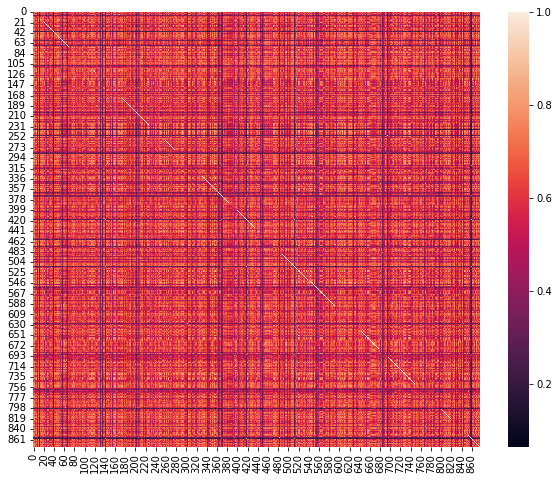

In [173]:
plt.figure(figsize=(10,8))
sn.heatmap(cor_mat)

we set 0 the main diagonal of matrix , since the inner product of each title is equal to 1 with itselt.
Then we Find the maximum cosine similarity  

In [252]:
cor_mat[cor_mat >= 0.99] = np.ma.array(0, mask=True)
ind = np.unravel_index(np.argmax(cor_mat, axis=None), cor_mat.shape) 
id=A['ID'].values

In [258]:
p1=id[ind[0]]
p2=id[ind[1]]
print("paper ID 1:",p1,'\n',"paper ID 2:",p2)

paper ID 1: 3cb410fa0a1e4a839e940971b599274b3efa8f5d 
 paper ID 2: f165373c6619cf8366e57b0418c6c1a8df1df0e7


In [260]:
print("Paper title 1:")
print(title_df[title_df['ID']== p1].compute().iloc[0]['title'])


Paper title 1:
ARTICLE IN PRESS +Model Revista Española de Anestesiología y Reanimación Recomendaciones de consenso respecto al soporte respiratorio no invasivo en el paciente adulto con insuficiencia respiratoria aguda secundaria a infección por SARS-CoV-2


In [261]:
print("Paper title 2:")
print(title_df[title_df['ID']== p2].compute().iloc[0]['title'])

Paper title 2:
Journal Pre-proof RECOMENDACIONES DEL GRUPO ESPAÑOL DE FOTOBIOLOGÍA DE LA AEDV EN REFERENCIA AL MANEJO DE LAS UNIDADES DE FOTOTERAPIA DURANTE LA PANDEMIA POR SARS-CoV-2 Sección: Cartas Científico Clínicas RECOMENDACIONES DEL GRUPO ESPAÑOL DE FOTOBIOLOGÍA DE LA AEDV EN REFERENCIA AL MANEJO DE LAS UNIDADES DE FOTOTERAPIA DURANTE LA PANDEMIA POR SARS-CoV-2 Management of Phototherapy Units During the COVID-19 Pandemic: Recommendations of the AEDV's Spanish Photobiology Group


<hr style="border-top-width:4px; border-top-color: #00df;">

### Analyze the number of partitions to be optimized 

In [206]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)

def timing_part_model(partitions):
    i = time.time() 

    #process
    model = ddf.read_table('/mnt/nfs_share/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None, 
                      sep=' ',
                      blocksize='20MB')
    model=model.repartition(npartitions=partitions)
    js = bag.map(json.loads)
    titles = js.map(extract_id_title)
    title_count = js.map(extract_id_title).pluck('title_tokens').map(count).flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()
    unique_words_title = [title_count[i][0] for i in range(0,len(title_count))]
    mask = model[0].isin(unique_words_title)
    filtered_model = model[mask]
    filtered_model = filtered_model.drop([301],axis=1).compute() #I want this to be a normal pandas dataframe
    f = time.time()
    return (f-i)

In [209]:
partitions=[4,8,16,25,50,100,500,2000]
ts_w12_3m=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_part_model(p)
    print('for partitions=',p,'timing is :', t)
    ts_w12_3m[c]=t
    c=c+1
    client.restart()
    time.sleep(1.5)

for partitions= 4 timing is : 54.55890440940857
for partitions= 8 timing is : 31.68472695350647
for partitions= 16 timing is : 31.28905177116394
for partitions= 25 timing is : 28.836256742477417
for partitions= 50 timing is : 29.658522605895996
for partitions= 100 timing is : 28.763015508651733
for partitions= 500 timing is : 31.809284210205078
for partitions= 2000 timing is : 45.13226628303528


Text(0.5, 1.0, 'Timing part 1 _task3')

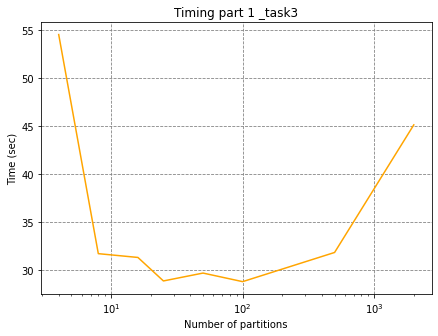

In [212]:
plt.figure(figsize=(7,5))
plt.plot(partitions,ts_w12_3m,c='orange')
plt.xscale('log')
plt.xlabel('Number of partitions')
plt.ylabel('Time (sec)')
plt.title('Timing part task 1')
plt.grid(color = 'gray', linestyle = '--')
plt.title('Timing part 1 _task3')

In [213]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)

def timing_part_model_MB(partitions):
    i = time.time() 

    #process
    model = ddf.read_table('/mnt/nfs_share/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None, 
                      sep=' ',
                      blocksize='20MB')
    model=model.repartition(npartitions=50)
    js = bag.map(json.loads)
    titles = js.map(extract_id_title)
    title_count = js.map(extract_id_title).pluck('title_tokens').map(count).flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()
    unique_words_title = [title_count[i][0] for i in range(0,len(title_count))]
    mask = model[0].isin(unique_words_title)
    filtered_model = model[mask]
    filtered_model = filtered_model.drop([301],axis=1).compute() 
    f = time.time()
    return (f-i)

In [194]:
#Different blocksize to load the model

partitions=['10MB','20MB','25MB','30MB','40MB']
ts_w12_3m=np.zeros(len(partitions))
c=0
for i in partitions:
    p=i
    t=timing_part_model_MB(p)
    print('blocksize=',p,'timing is :', t)
    ts_w12_3m[c]=t
    c=c+1
    client.restart()
    time.sleep(1.5)

blocksize= 10MB timing is : 29.19906759262085
blocksize= 20MB timing is : 24.469014883041382
blocksize= 25MB timing is : 25.515692234039307
blocksize= 30MB timing is : 24.796677589416504
blocksize= 40MB timing is : 24.898247480392456
